# Image Caption Generator

In this notebook We will implement Image caption generator. we will be using flicker 8k dataset for training
- **STEPS :**
  - Loading Required Modules
  -  Downloading dataset from kaggle
  - Loading the dataset
  - Loading The Images
  - Feature extraction from Images 
  - Loading Captions 
  - Cleaning Captions
  - Converting Text to embeddings
  - Splitting the dataset into training and Testing
  - Implementing Model
  - Testing the model
  - Implemeting Pediction function


### Imporing Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import plot_model

### Downloading Dataset

In [2]:
#downloading the data
#Preparing Kaggle command 
%%bash
echo  -e '{"username":"jarupulapremkumar","key":"f514f71ad21dbebdeec652df320135e9"}' >>kaggle.json
pip install kaggle --quiet
mkdir ~/.kaggle
mv kaggle.json ~/.kaggle
cat ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

{"username":"jarupulapremkumar","key":"f514f71ad21dbebdeec652df320135e9"}


In [3]:
!kaggle datasets download jaykumar2862/flicker-8k

100% 1.04G/1.04G [00:31<00:00, 40.5MB/s]
100% 1.04G/1.04G [00:31<00:00, 34.8MB/s]


In [4]:
!unzip -o flicker-8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Flicker8k_Dataset/2846843520_b0e6211478.jpg  
  inflating: dataset/Flicker8k_Dataset/2847514745_9a35493023.jpg  
  inflating: dataset/Flicker8k_Dataset/2847615962_c330bded6e.jpg  
  inflating: dataset/Flicker8k_Dataset/2847859796_4d9cb0d31f.jpg  
  inflating: dataset/Flicker8k_Dataset/2848266893_9693c66275.jpg  
  inflating: dataset/Flicker8k_Dataset/2848571082_26454cb981.jpg  
  inflating: dataset/Flicker8k_Dataset/2848895544_6d06210e9d.jpg  
  inflating: dataset/Flicker8k_Dataset/2848977044_446a31d86e.jpg  
  inflating: dataset/Flicker8k_Dataset/2849194983_2968c72832.jpg  
  inflating: dataset/Flicker8k_Dataset/2850719435_221f15e951.jpg  
  inflating: dataset/Flicker8k_Dataset/2851198725_37b6027625.jpg  
  inflating: dataset/Flicker8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: dataset/Flicker8k_Dataset/2851931813_eaf8ed7be3.jpg  
  inflating: dataset/Flicker8k_Dataset/2852982055_8112d0964f.jpg  
  inflating

### Loading the Dataset and Images

In [5]:
IMAGE_DIR = 'dataset/Flicker8k_Dataset/'
CAPTION_DIR = 'text/'

### Implementing class to perform all activites

In [6]:
class Image_Caption_Generator():
  def __init__(self):
    pass
  
  def get_Image_Feature(self,model = None,image_path = None):
    
    '''
    INPUTS:
          Model : Provide A model That helps us to extract the Image features.
          Image_path :provide path of single image.

    OUTPUTS:
          return features of images

    '''

    features = []


    if image_path == None:
      print('Please provide the Path to get required outcome')
    elif model == None:
      print("Please provide the model for feature Extraction")
    else:
      # load the image from path
      image = load_img(image_path, target_size=(224, 224))
      # convert image pixels to numpy array
      image = img_to_array(image)
      # reshape data for model
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      # preprocess image for vgg
      image = preprocess_input(image)
      # extract features
      feature = model.predict(image, verbose=0)

      return feature

  def get_Images_Feature(self,model = None,image_folder_path = None,image_names = None,has_Extension = False,extension = 'jpg'):

    '''
    INPUTS:
          Model : Provide A model That helps us to extract the Image features.
          Image_folder_path :provide path of image folder.
          images_names = List of Images Name
          Has_extension = 

    OUTPUTS:
          return dictionary features of images along with features.
          key is image name without extension and
          value is feture of image
           eg: {image_name:feature}

    '''
    features = {}
    if image_folder_path == None:
        print('Please provide the Path to get required outcome')
    elif model == None:
        print("Please provide the model for feature Extraction")
    else:

      for img_name in tqdm(image_names):
      # load the image from file

        if has_Extension == True :
          img_path = image_folder_path + img_name + "." + extension
        else:
          img_path = image_folder_path + img_name 

        image = load_img(img_path, target_size=(224, 224))
        # convert image pixels to numpy array
        image = img_to_array(image)
        # reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # preprocess image for vgg
        image = preprocess_input(image)
        # extract features
        feature = model.predict(image, verbose=0)
        # get image ID
        image_id = img_name.split('.')[0]
        # store feature
        features[image_id] = feature

    return features

  def preprocessing_Text(self,text = None):
    # preprocessing steps
    # convert to lowercase
    text = text.lower()
    # delete digits, special chars, etc., 
    text = text.replace('[^A-Za-z]', '')
    # delete additional spaces
    text = text.replace('\s+', ' ')
    return text
  
  def preprocess_Captions(self,mappings = None):
    '''
    mappings:  is dict of captions 
              with key as
    '''
    out_mappings = {}
    for key, captions in mappings.items():
        preprocessed_captions = []
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            preprocessed_captions.append(caption)

        out_mappings[key] = preprocessed_captions

    return out_mappings

  def readTextFile(self,file_path = None):
    captions = ''
    with open(file_path) as f:
      captions = f.read()
    
    return captions

  def data_generator(self,data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [7]:
# defining Class Object
icg_obj = Image_Caption_Generator()

### Feature extraction from Images

In [8]:
# load vgg16 model
model_cnn = VGG16()
# restructure the model
model_cnn = Model(inputs=model_cnn.inputs, outputs=model_cnn.layers[-2].output)
# summarize
print(model_cnn.summary())

553476096/553467096 [==============================] - 16s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

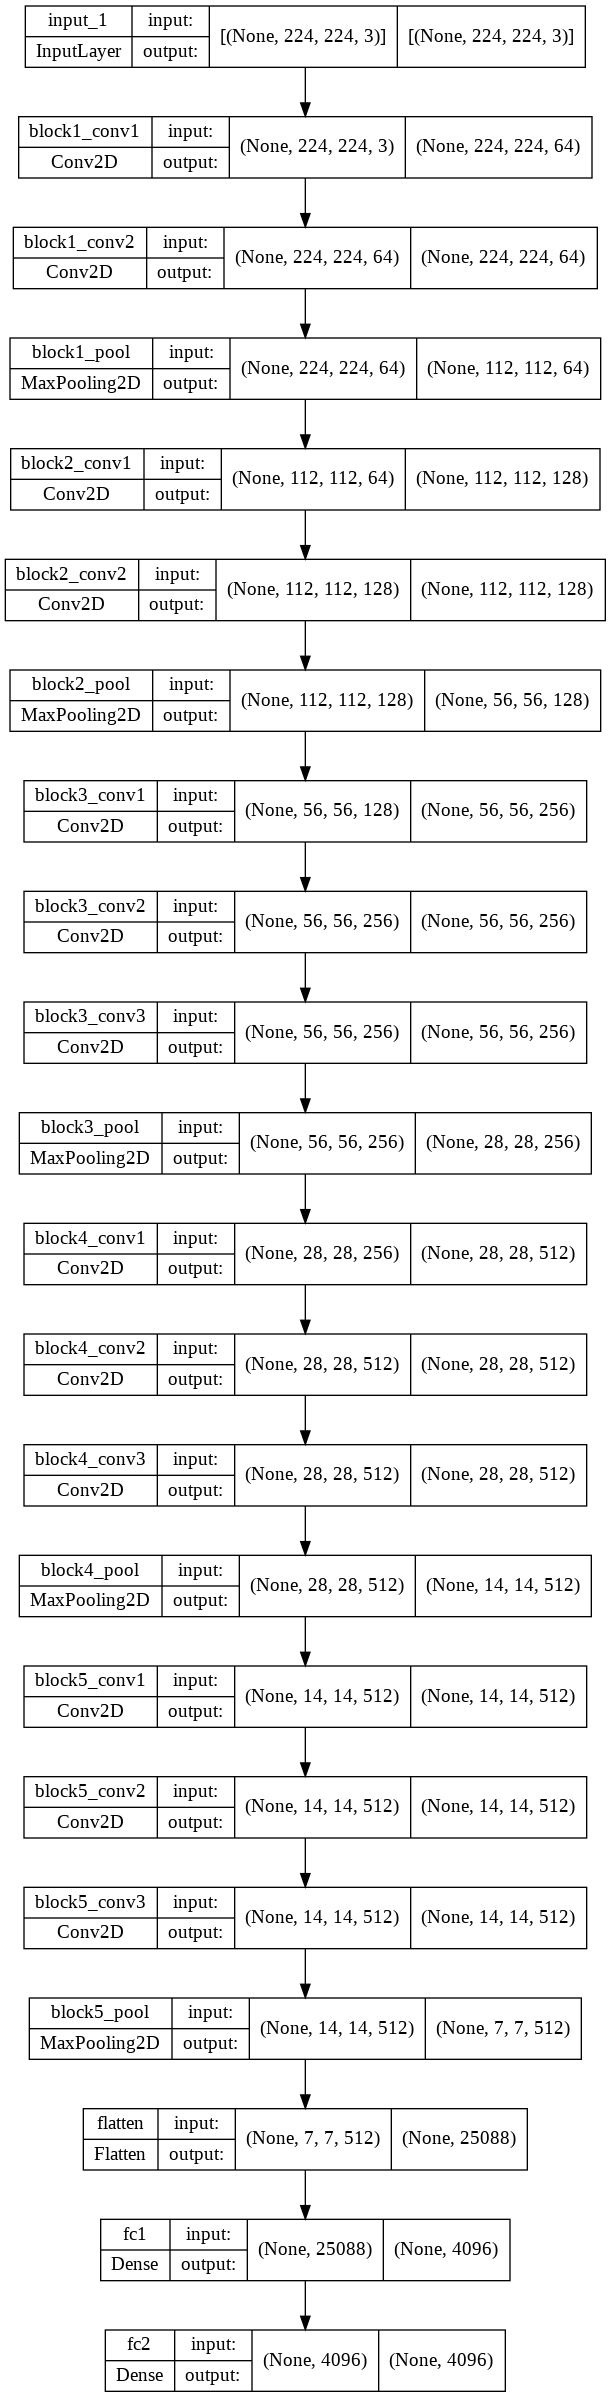

In [9]:
plot_model(model_cnn,show_shapes=True)

In [10]:
#getting list of images or image names 
image_names = os.listdir(IMAGE_DIR)

In [11]:
features_dict = icg_obj.get_Images_Feature(model = model_cnn,image_folder_path=IMAGE_DIR,image_names = image_names)
features_dict

  0%|          | 0/8091 [00:00<?, ?it/s]

{'1453366750_6e8cf601bf': array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         1.1884089]], dtype=float32),
 '2158267555_db1d94e468': array([[0.        , 0.        , 0.        , ..., 0.        , 0.42479354,
         0.        ]], dtype=float32),
 '484896012_7787d04f41': array([[0.       , 0.       , 2.9961758, ..., 0.       , 2.800361 ,
         1.4206932]], dtype=float32),
 '3677734351_63d60844cb': array([[0.73308104, 0.        , 0.        , ..., 0.        , 4.37129   ,
         0.        ]], dtype=float32),
 '756521713_5d3da56a54': array([[0.       , 0.       , 4.4398637, ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '942399470_6132d3e5d2': array([[0.        , 0.        , 0.        , ..., 0.3998036 , 0.42022425,
         0.        ]], dtype=float32),
 '362316425_bda238b4de': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '944788251_a0bcd4b960': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '1417637704_572b4d6557': array([

In [12]:
#saving thefeatures_dict using pickle
pickle.dump(features_dict, open('features.pkl', 'wb'))

In [13]:
# load features from pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

- Now we Have features of Images , will continue captions part

### Working With Caption Data


In [14]:
#loading the captions
captions_txt = icg_obj.readTextFile(CAPTION_DIR+'Flickr8k.token.txt') 
captions_txt


'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [15]:
# create mapping of image to captions
mappings = {}
# process lines
for line in captions_txt.split('\n'):
    if(len(line.split('\t')) == 2):
      img,caption = line.split('\t')
    img_name = img.split('.')[0]
    #if the img_name is already present in dict then we will extend the caption list
    if mappings.get(img_name) is None:
      mappings[img_name] = []
    else:
      mappings[img_name].append(caption)


In [16]:
mappings['2090723611_318031cfa5']

['Large fluffy grey dog standing in grass in front of a brown dog .',
 'one dog standing in some grass with his tongue hanging out and a tan dog in the background',
 'Two dogs of different breeds are standing in a pasture .',
 'Two dogs stand in the grass .']

In [17]:
#preprocessing captions
clean_mappings = icg_obj.preprocess_Captions(mappings=mappings)

In [18]:
clean_mappings['2090723611_318031cfa5']

['startseq large fluffy grey dog standing in grass in front of brown dog endseq',
 'startseq one dog standing in some grass with his tongue hanging out and tan dog in the background endseq',
 'startseq two dogs of different breeds are standing in pasture endseq',
 'startseq two dogs stand in the grass endseq']

In [19]:
#merging all the captions in single list for getting vocab
all_captions = []
for key in clean_mappings:
    for caption in clean_mappings[key]:
        all_captions.append(caption)

In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)


In [21]:
len(tokenizer.word_index)

7731

In [22]:
# since we pad 0 to our we need to add so we add 1 so we no need to face problem while embedding
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7732

In [23]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

### Spliting Data into train and test

In [26]:
# loading train, valiation,test captions as well
train_images_names = icg_obj.readTextFile(CAPTION_DIR+'Flickr_8k.devImages.txt')
val_images_names = icg_obj.readTextFile(CAPTION_DIR+'Flickr_8k.testImages.txt')
test_images_names = icg_obj.readTextFile(CAPTION_DIR+'Flickr_8k.trainImages.txt')

In [36]:
#geting image_names for train,test
train_images = []
val_images =[]
test_images = []

#getting image_names as keys in clean mappings
for image_name in train_images_names.split('\n'):
  if len(image_name.split('.')[0]) > 2:
    train_images.append(image_name.split('.')[0])

for image_name in val_images_names.split('\n'):
  if len(image_name.split('.')[0]) > 2:
    train_images.append(image_name.split('.')[0])

for image_name in test_images_names.split('\n'):
  if len(image_name.split('.')[0]) > 2:
    test_images.append(image_name.split('.')[0])

### Defining Model

**ENCODER PART**

In [28]:
# image feature layers
input_1 = Input(shape=(4096,),)
fe1 = Dropout(0.4)(input_1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
input_2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input_2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

**DECODER PART**

In [29]:
# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


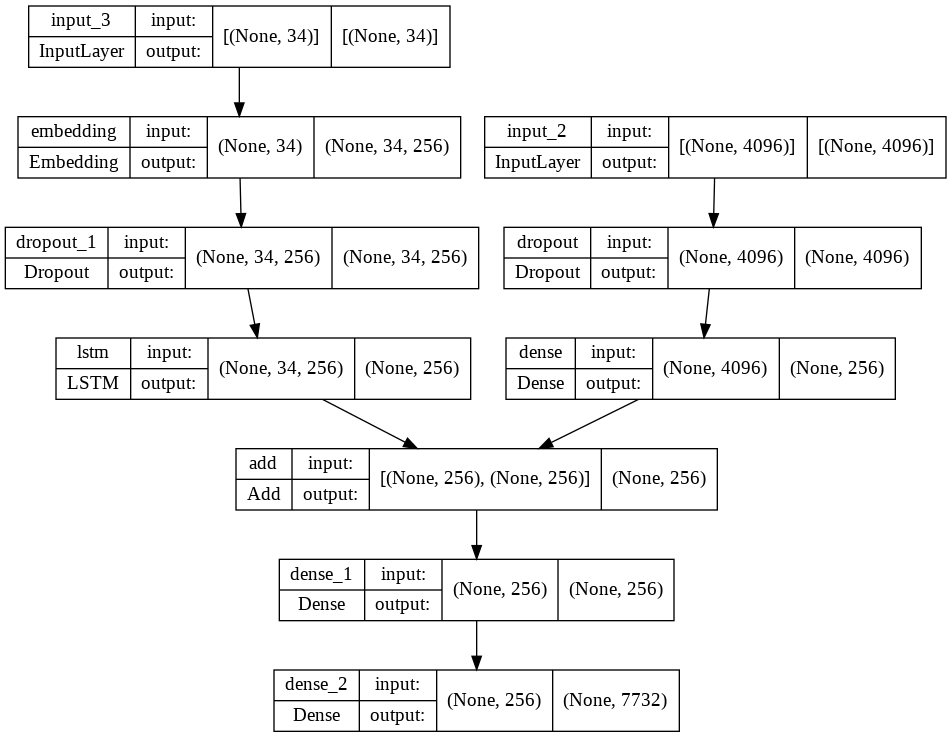

In [30]:
# plot the model
plot_model(model, show_shapes=True)

### Training Model


In [37]:
# train the model
epochs = 50
batch_size = 32
steps = len(train_images) // batch_size

for i in range(epochs):
    # create data generator
    generator = icg_obj.data_generator(train_images, clean_mappings, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

62/62 [==============================] - 15s 247ms/step - loss: 1.0599


In [38]:
# save the model
model.save('best_model.h5')

### Defining Predict Function

In [39]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [40]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [42]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_images):
    # get actual caption
    captions = clean_mappings[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/6000 [00:00<?, ?it/s]

BLEU-1: 0.487754
BLEU-2: 0.257530


**Results**

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(IMAGE_DIR+image_name)
    image = Image.open(img_path)
    captions = clean_mappings[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs playing on the dirt endseq


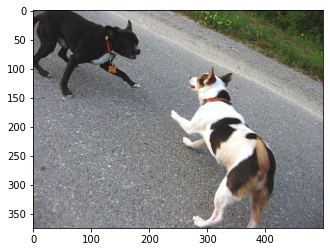

In [44]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq large fluffy grey dog standing in grass in front of brown dog endseq
startseq one dog standing in some grass with his tongue hanging out and tan dog in the background endseq
startseq two dogs of different breeds are standing in pasture endseq
startseq two dogs stand in the grass endseq
--------------------Predicted--------------------
startseq two dogs are running over an obstacle endseq


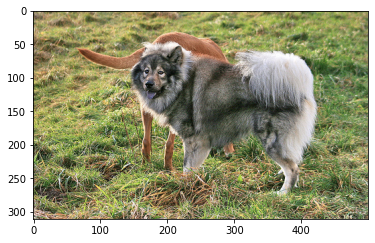

In [45]:
generate_caption("2090723611_318031cfa5.jpg")

---------------------Actual---------------------
startseq blond woman is on the street hailing taxi endseq
startseq woman is signaling is to traffic as seen from behind endseq
startseq woman with blonde hair wearing blue tube top is waving on the side of the street endseq
startseq the woman in the blue dress is holding out her arm at oncoming traffic endseq
--------------------Predicted--------------------
startseq woman is signaling is waving on the side of the street endseq


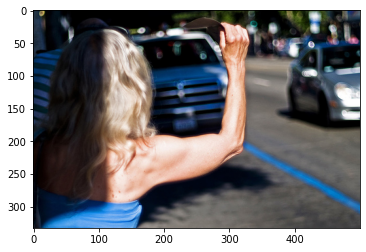

In [46]:
generate_caption("1056338697_4f7d7ce270.jpg")